# Discrete-time linear tracking experimenting using numpy and TensorFlow

Author: Simo Särkkä

Linear tracking experiment which represents a point-target that follows a random trajectory.
The first part is pure numpy and doesn't need TensorFlow to run, the second does.

## Imports

In [1]:
import numpy as np
import parallel_control.linear_model_np as linear_model_np
import matplotlib.pyplot as plt

## Generate and plot the data from car model

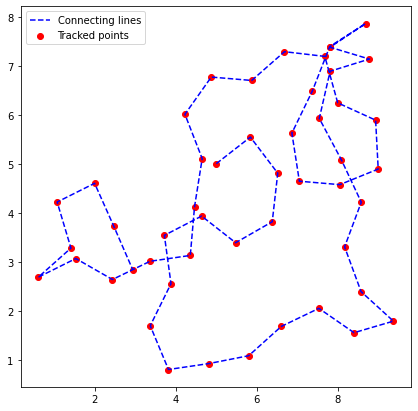

In [2]:
model = linear_model_np.LinearModel()
xy = model.genData(50)

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(xy[0,:], xy[1,:], label="Connecting lines", color="b", linestyle="--")
ax.scatter(xy[0,:], xy[1,:], label="Tracked points", color="r")
_ = plt.legend()

## Run sequential numpy LQT and plot it

In [3]:
lqt, x0 = model.getLQT(xy)

Kx_list_seq, d_list_seq, S_list_seq, v_list_seq = lqt.seqBackwardPass()
u_list_seq, x_list_seq = lqt.seqForwardPass(x0,Kx_list_seq,d_list_seq)

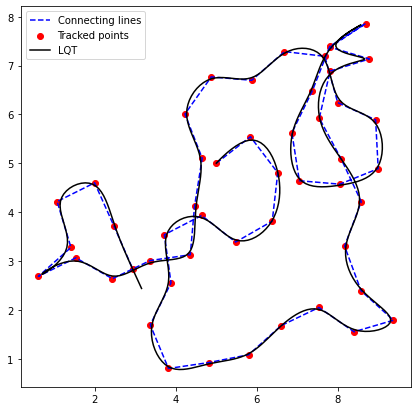

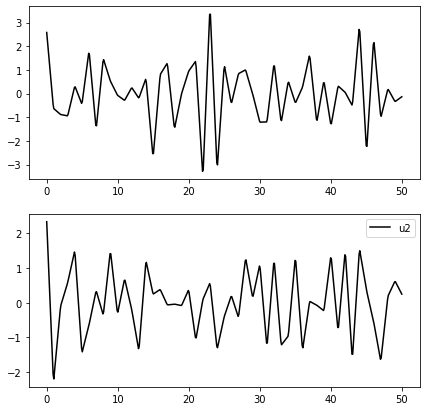

In [4]:
x_seq = np.array(x_list_seq).T
u_seq = np.array(u_list_seq).T

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(xy[0,:], xy[1,:], label="Connecting lines", color="b", linestyle="--")
ax.scatter(xy[0,:], xy[1,:], label="Tracked points", color="r")
ax.plot(x_seq[0,:], x_seq[1,:], label="LQT", color="k")
_ = plt.legend()

np.savetxt('res/lqt_xy.txt',xy)
np.savetxt('res/lqt_x_seq.txt',x_seq)

times = np.linspace(0, xy.shape[1], u_seq.shape[1])
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(7, 7))
ax1.plot(times, u_seq[0,:], label="u1", color="k")
ax2.plot(times, u_seq[1,:], label="u2", color="k")
_ = plt.legend()

## Run Parallel numpy LQT, plot, and check results


In [5]:
Kx_list_par, d_list_par, S_list_par, v_list_par = lqt.parBackwardPass()
u_list_par1, x_list_par1 = lqt.parForwardPass(x0,Kx_list_par,d_list_par)
u_list_par2, x_list_par2 = lqt.parFwdBwdPass(x0,Kx_list_par,d_list_par,S_list_par,v_list_par)

pLQT1 vs. LQT x-diff = 1.60427e-14
pLQT1 vs. LQT u-diff = 7.10543e-14
pLQT2 vs. LQT x-diff = 1.69142e-13
pLQT2 vs. LQT u-diff = 4.36984e-13


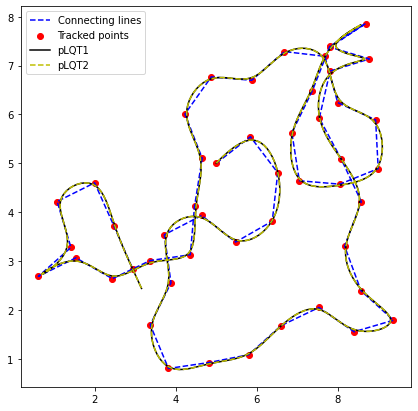

In [6]:
x_par1 = np.array(x_list_par1).T
u_par1 = np.array(u_list_par1).T
x_par2 = np.array(x_list_par2).T
u_par2 = np.array(u_list_par2).T

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(xy[0,:], xy[1,:], label="Connecting lines", color="b", linestyle="--")
ax.scatter(xy[0,:], xy[1,:], label="Tracked points", color="r")
ax.plot(x_par1[0,:], x_par1[1,:], label="pLQT1", color="k")
ax.plot(x_par2[0,:], x_par2[1,:], label="pLQT2", color="y", linestyle="--")
_ = plt.legend()

print("pLQT1 vs. LQT x-diff = %g" % np.max(np.abs(x_par1 - x_seq)))
print("pLQT1 vs. LQT u-diff = %g" % np.max(np.abs(u_par1 - u_seq)))
print("pLQT2 vs. LQT x-diff = %g" % np.max(np.abs(x_par2 - x_seq)))
print("pLQT2 vs. LQT u-diff = %g" % np.max(np.abs(u_par2 - u_seq)))

---

## Imports for the second (TensorFlow) part

In [7]:
import tensorflow as tf
import parallel_control.lqt_tf as lqt_tf

## Convert the model into TensorFlow format and run the sequential LQT in TensorFlow

Num GPUs Available:  0
TF-LQT vs. LQT x-diff = 9.9365e-15
TF-LQT vs. LQT u-diff = 7.10543e-14


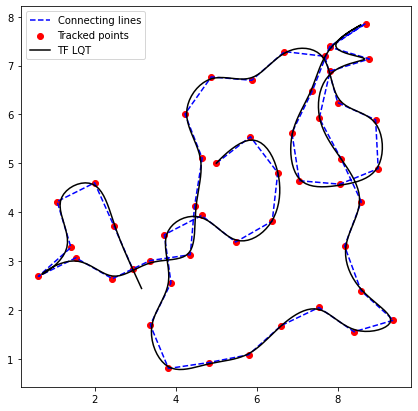

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

with tf.device('/GPU:0'):
    Fs, cs, Ls, Hs, HT, rs, rT, Xs, XT, Us = lqt_tf.lqt_np_to_tf(lqt, dtype=tf.float64)
    x0_tf = tf.convert_to_tensor(x0, dtype=Fs.dtype)

    Ss, vs, Kxs, ds = lqt_tf.lqt_seq_backwardpass(Fs, cs, Ls, Hs, HT, rs, rT, Xs, XT, Us)
    xs_tf_seq, us_tf_seq = lqt_tf.lqt_seq_forwardpass(x0_tf, Fs, cs, Ls, Kxs, ds)

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(xy[0,:], xy[1,:], label="Connecting lines", color="b", linestyle="--")
ax.scatter(xy[0,:], xy[1,:], label="Tracked points", color="r")
ax.plot(xs_tf_seq[:,0].numpy(), xs_tf_seq[:,1].numpy(), label="TF LQT", color="k")
_ = plt.legend()

print("TF-LQT vs. LQT x-diff = %g" % np.max(np.abs(xs_tf_seq.numpy() - x_seq.T)))
print("TF-LQT vs. LQT u-diff = %g" % np.max(np.abs(us_tf_seq.numpy() - u_seq.T)))

## Run parallel LQTs on TensorFlow with float64

In [9]:
with tf.device('/GPU:0'):
    Fs, cs, Ls, Hs, HT, rs, rT, Xs, XT, Us = lqt_tf.lqt_np_to_tf(lqt, dtype=tf.float64)
    x0_tf = tf.convert_to_tensor(x0, dtype=Fs.dtype)

    Ss, vs, Kxs, ds = lqt_tf.lqt_par_backwardpass(Fs, cs, Ls, Hs, HT, rs, rT, Xs, XT, Us)
    xs_tf_par1, us_tf_par1 = lqt_tf.lqt_par_forwardpass(x0_tf, Fs, cs, Ls, Kxs, ds)

print("TF-pLQT1 vs. LQT x-diff = %g" % np.max(np.abs(xs_tf_par1.numpy() - x_seq.T)))
print("TF-pLQT1 vs. LQT u-diff = %g" % np.max(np.abs(us_tf_par1.numpy() - u_seq.T)))

with tf.device('/GPU:0'):
    Fs, cs, Ls, Hs, HT, rs, rT, Xs, XT, Us = lqt_tf.lqt_np_to_tf(lqt, dtype=tf.float64)
    x0_tf = tf.convert_to_tensor(x0, dtype=Fs.dtype)

    Ss, vs, Kxs, ds = lqt_tf.lqt_par_backwardpass(Fs, cs, Ls, Hs, HT, rs, rT, Xs, XT, Us)
    xs_tf_par2, us_tf_par2 = lqt_tf.lqt_par_fwdbwdpass(x0_tf, Fs, cs, Ls, Hs, rs, Xs, Us, Ss, vs, Kxs, ds)

print("TF-pLQT2 vs. LQT x-diff = %g" % np.max(np.abs(xs_tf_par2.numpy() - x_seq.T)))
print("TF-pLQT2 vs. LQT u-diff = %g" % np.max(np.abs(us_tf_par2.numpy() - u_seq.T)))

TF-pLQT1 vs. LQT x-diff = 1.42109e-14
TF-pLQT1 vs. LQT u-diff = 7.10543e-14
TF-pLQT2 vs. LQT x-diff = 1.69073e-13
TF-pLQT2 vs. LQT u-diff = 4.40536e-13


## Run parallel LQTs on TensorFlow with float32

In [10]:
with tf.device('/GPU:0'):
    Fs, cs, Ls, Hs, HT, rs, rT, Xs, XT, Us = lqt_tf.lqt_np_to_tf(lqt, dtype=tf.float32)
    x0_tf = tf.convert_to_tensor(x0, dtype=Fs.dtype)

    Ss, vs, Kxs, ds = lqt_tf.lqt_par_backwardpass(Fs, cs, Ls, Hs, HT, rs, rT, Xs, XT, Us)
    xs_tf_par1, us_tf_par1 = lqt_tf.lqt_par_forwardpass(x0_tf, Fs, cs, Ls, Kxs, ds)

print("TF-pLQT1 vs. LQT x-diff = %g" % np.max(np.abs(xs_tf_par1.numpy() - x_seq.T)))
print("TF-pLQT1 vs. LQT u-diff = %g" % np.max(np.abs(us_tf_par1.numpy() - u_seq.T)))

with tf.device('/GPU:0'):
    Fs, cs, Ls, Hs, HT, rs, rT, Xs, XT, Us = lqt_tf.lqt_np_to_tf(lqt, dtype=tf.float32)
    x0_tf = tf.convert_to_tensor(x0, dtype=Fs.dtype)

    Ss, vs, Kxs, ds = lqt_tf.lqt_par_backwardpass(Fs, cs, Ls, Hs, HT, rs, rT, Xs, XT, Us)
    xs_tf_par2, us_tf_par2 = lqt_tf.lqt_par_fwdbwdpass(x0_tf, Fs, cs, Ls, Hs, rs, Xs, Us, Ss, vs, Kxs, ds)

print("TF-pLQT2 vs. LQT x-diff = %g" % np.max(np.abs(xs_tf_par2.numpy() - x_seq.T)))
print("TF-pLQT2 vs. LQT u-diff = %g" % np.max(np.abs(us_tf_par2.numpy() - u_seq.T)))



TF-pLQT1 vs. LQT x-diff = 5.66524e-06
TF-pLQT1 vs. LQT u-diff = 4.29256e-05
TF-pLQT2 vs. LQT x-diff = 6.92726e-05
TF-pLQT2 vs. LQT u-diff = 0.000187543


## Run a speedtest

In [12]:
import parallel_control.linear_speedtest as linspeed

device = '/GPU:0'
# device = '/CPU:0'

lqt_gen = linspeed.tracking_generator(2, 3, 10)
T1, D1, run_times1 = linspeed.lqt_sequential_bw_speedtest(lqt_gen, device=device)

lqt_gen = linspeed.tracking_generator(2, 3, 10)
T2, D2, run_times2 = linspeed.lqt_parallel_bw_speedtest(lqt_gen, device=device)

Running lqt_sequential_bw_speedtest on device /GPU:0
Tracking T_list = [ 100  129  166  215  278  359  464  599  774 1000]
T=100, D=4 took 7.372713 ms
T=120, D=4 took 8.012486 ms
T=160, D=4 took 10.247278 ms
T=210, D=4 took 13.023996 ms
T=270, D=4 took 16.305780 ms
T=350, D=4 took 20.295978 ms
T=460, D=4 took 25.686669 ms
T=590, D=4 took 33.741784 ms
T=770, D=4 took 47.292805 ms
T=1000, D=4 took 53.243995 ms
Running lqt_parallel_bw_speedtest on device /GPU:0
Tracking T_list = [ 100  129  166  215  278  359  464  599  774 1000]
T=100, D=4 took 1.442099 ms
T=120, D=4 took 1.487494 ms
T=160, D=4 took 1.762295 ms
T=210, D=4 took 2.125692 ms
T=270, D=4 took 2.489305 ms
T=350, D=4 took 2.880311 ms
T=460, D=4 took 3.714490 ms
T=590, D=4 took 4.396009 ms
T=770, D=4 took 5.466199 ms
T=1000, D=4 took 6.737685 ms


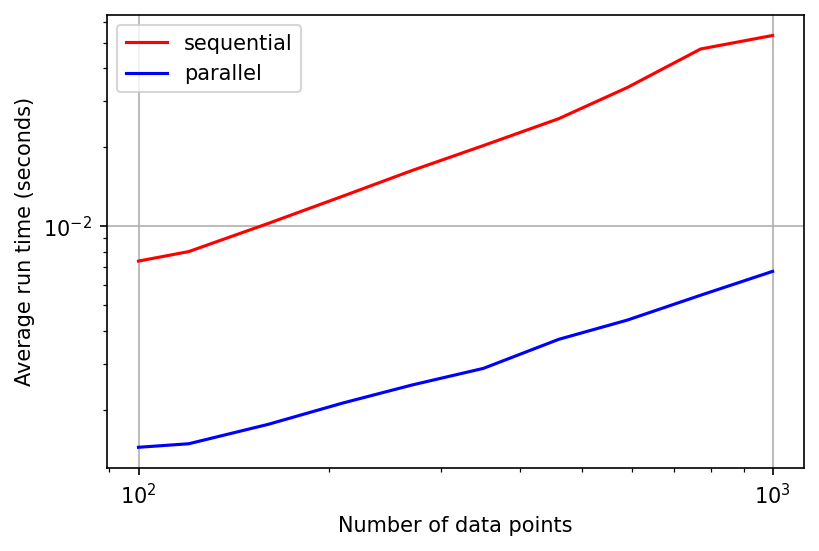

In [13]:
fig = plt.figure(1, dpi=150)
plt.loglog(T1, run_times1, label="sequential", linestyle="-", color="r")
plt.loglog(T2, run_times2, label="parallel", linestyle="-", color="b")
plt.legend()
plt.xlabel("Number of data points")
plt.ylabel("Average run time (seconds)")
plt.grid()
plt.show()


